In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## ABOUT CIFAR-10 DATASET:

CIFAR-10 is an established computer-vision dataset used for object recognition. It is a subset of the **80 million tiny images dataset** and consists of **60,000 32x32 color images** containing one of **10 object classes**, with **6000 images per class**. It was collected by **Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton**.

The CIFAR-10 data consists of **60,000 32x32 color images** in **10 classes**, with **6000 images per class**. There are **50,000 training images** and **10,000 test images** in the official data. We have preserved the train/test split from the original dataset.  

#### The provided files in the dataset are:
- `train.7z` - A folder containing the training images in PNG format  
- `test.7z` - A folder containing the test images in PNG format  
- `trainLabels.csv` - The training labels  

To discourage certain forms of cheating (such as hand labeling), we have added **290,000 junk images** in the test set. These images are ignored in the scoring. We have also made trivial modifications to the official **10,000 test images** to prevent looking them up by file hash. These modifications should not appreciably affect the scoring. **You should predict labels for all 300,000 images.**

#### **The label classes in the dataset are:**
- **airplane**  
- **automobile**  
- **bird**  
- **cat**  
- **deer**  
- **dog**  
- **frog**  
- **horse**  
- **ship**  
- **truck**  

The classes are **completely mutually exclusive**. There is **no overlap** between automobiles and trucks.  
- **"Automobile"** includes sedans, SUVs, and similar vehicles.  
- **"Truck"** includes only large trucks.  
- **Pickup trucks are not included** in either category.  


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# List all files in "MyDrive"
import os
print(os.listdir('/content/drive/MyDrive/'))

# Print all files in CIFAR-10 folder made on my drive:
print(os.listdir('/content/drive/MyDrive/CIFAR-10/'))

# Extracting zip file in CIFAR-10 folder:
import zipfile

zip_path = "/content/drive/MyDrive/CIFAR-10/zip folder/train.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:             # Opens the ZIP file (train.zip) in read mode ('r'). zip_ref is a ZipFile object that allows access to the contents.
    zip_ref.extractall("/content/")                     # Extracts the ZIP file's contents to /content/, which is Google Colab's temporary storage. After extraction, the images
                                                            # will be inside /content/train/ if the ZIP contained a train/ folder.

# New file location according to colab
path = "/content/train" #r'C:\Users\HARSH\OneDrive\Documents\Deep Learning Projects\CIFAR-10 Object Detection\cifar-10\train\train'
# This is the training data path; this folder contains 50K images of 10 different objects that we will use to train our model.

path_csv = "/content/drive/MyDrive/CIFAR-10/trainLabels.csv"

Mounted at /content/drive
['VTU-programme-application.pdf', 'Colab Notebooks', 'CIFAR-10']
['trainLabels.csv', 'zip folder']


## TRAINING DATA:

In [3]:
#path = r'C:\Users\HARSH\OneDrive\Documents\Deep Learning Projects\CIFAR-10 Object Detection\cifar-10\train'
# This is the training data path; this folder contains 50K images of 10 different objects that we will use to train our model.

#path_csv = r'C:\Users\HARSH\OneDrive\Documents\Deep Learning Projects\CIFAR-10 Object Detection\cifar-10\trainLabels.csv'
# This CSV file contains the labels of those 50K images; i.e if the image in the training folder is 1357.png then in the CSV file the id no.: 1357 will
# tell what the image is of a car, or a frog, etc.

file = os.listdir(path)         # Returns a list of all files/folders(here we have images as files) in the given directory (path), and stores them in
                                # the variable 'file'.
print(type(file))
print(len(file))

print(file[0: 5], file[-5: ])   # Prints the first 5 and the last 5 images of the file

<class 'list'>
50000
['45877.png', '43417.png', '13991.png', '30145.png', '41652.png'] ['7544.png', '28139.png', '10055.png', '48496.png', '7794.png']


In [4]:
train_label = pd.read_csv(path_csv)     # Storing the labels of the training data in datafame name 'train_label'
print(train_label.shape)

(50000, 2)


In [5]:
train_label.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [6]:
train_label[train_label["id"] == 100]                      # Seeing 100.png is what image

,id,label
99,100,automobile


In [7]:
train_label['label'].value_counts()                        # To see how many different images are there, and what are there counts

,count
label,
frog,5000
truck,5000
deer,5000
automobile,5000
bird,5000
horse,5000
ship,5000
cat,5000
dog,5000


## ENCODING THE LABELS:

In [8]:
label_dic = {'airplane' : 0, 'automobile' : 1, 'bird' : 2, 'cat' : 3, 'deer' : 4, 'dog' : 5, 'frog' : 6, 'horse' : 7, 'ship' : 8, 'truck' : 9}

label = []

for i in train_label['label']:
    val = label_dic[i]
    label.append(val)

In [9]:
print(train_label[0:5], '\n\nThere corresponding Labels are: ', label[0:5], '\n')
print(train_label[-5:], '\n\nThere corresponding Labels are: ', label[-5:], '\n')

   id       label
0   1        frog
1   2       truck
2   3       truck
3   4        deer
4   5  automobile 

There corresponding Labels are:  [6, 9, 9, 4, 1] 

          id       label
49995  49996        bird
49996  49997        frog
49997  49998       truck
49998  49999  automobile
49999  50000  automobile 

There corresponding Labels are:  [2, 6, 9, 1, 1] 



## CONVERING TRAINING IMAGES INTO Numpy ARRAY:

In [10]:
# Here as we can see our labels are in order (id: 1 to 50000), but our training data is not in order as seen above ie: the first 3 images are 1.png,
# 10.png, 100.png. So now we will create a list that contains the Numpy array of all images in the same order as in the list 'label'(ie: 1 to 50000).

train_data_folder = "/content/train/" #r"C:\Users\HARSH\OneDrive\Documents\Deep Learning Projects\CIFAR-10 Object Detection\cifar-10\train\\"

training_img = []

for i in train_label['id']:

    img_path = train_data_folder + str(i) + ".png"    # Creating the image path for the i th image in the train folder

    img = cv2.imread(img_path)                        # Converting the i th image into numpy array

    training_img.append(img)                          # Adding this numpy array of the i th image in the list "training_img"

In [11]:
print(type(training_img), '\nNumber of Images: ', len(training_img))

<class 'list'> 
Number of Images:  50000


In [12]:
print('The data-type of an element: ', type(training_img[0]), '\nShape of an element: ', training_img[0].shape)

The data-type of an element:  <class 'numpy.ndarray'> 
Shape of an element:  (32, 32, 3)


In [13]:
# Converting list into Numpy array. In machine learning and data science, NumPy arrays (numpy.ndarray) are preferred over Python lists because
# of performance, efficiency, and functionality.

x = np.array(training_img)
y = np.array(label)

print('Type of training_img: ', type(x), 'and of label: ', type(y))
print('\nShape of training_img: ', x.shape, 'and of label: ', y.shape)

Type of training_img:  <class 'numpy.ndarray'> and of label:  <class 'numpy.ndarray'>

Shape of training_img:  (50000, 32, 32, 3) and of label:  (50000,)


## TRAIN TEST SPLIT:

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
# Here our test size is 20% of the total data, and we use random_state = 42 for having same distribution of train & test data every time.

In [15]:
print(x.shape, x_train.shape, x_test.shape)

(50000, 32, 32, 3) (40000, 32, 32, 3) (10000, 32, 32, 3)


## SCALING THE TRAINING DATA:

In [16]:
x_train_scaled = x_train/255
x_test_scaled = x_test/255

## BUILDING THE NEURAL NETWORK:

In [17]:
import tensorflow as tf
from tensorflow import keras

In [18]:
# Setting the neural network

num_of_classes = 10

model = keras.Sequential([
                          keras.layers.Flatten(input_shape = (32, 32, 3)),
                          keras.layers.Dense(64, activation = 'relu'),     # We always give no. of neurons in power of 2 for better computation like 32,
                                                                           # 64, 128, etc. but it is not a rule we can use any number of neurons
                          keras.layers.Dense(num_of_classes, activation = 'softmax')    # We generally use 'sigmoid' & 'softmax' as activation in o/p
])                                                                                      # layer for binary & multi-class classification.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Comparison With Other Activation Functions:**
| Activation Function | Use Case |
|---------------------|----------|
| **Softmax** | Multi-class classification (output sum = 1) |
| **Sigmoid** | Binary classification (output between 0 and 1) |
| **ReLU** | Hidden layers (for feature extraction) |

In [19]:
# Compiling the model

model.compile(optimizer = 'adam',
               loss = 'sparse_categorical_crossentropy',  # Here if we used one-hot encoding then we could use categorical_crossentropy, but we scaled
                                                        # our data normally so we had use sparse_categorical_crossentropy, otherwise it will give error.
               metrics = ['acc'] )

## TRAINING OUR NEURAL NETWORK MODEL:

In [20]:
model.fit(x_train_scaled, y_train, validation_split = 0.1, epochs = 10)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - acc: 0.2482 - loss: 2.0746 - val_acc: 0.3070 - val_loss: 1.8892
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - acc: 0.3472 - loss: 1.8393 - val_acc: 0.3627 - val_loss: 1.8157
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - acc: 0.3660 - loss: 1.7828 - val_acc: 0.3543 - val_loss: 1.7929
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.3821 - loss: 1.7422 - val_acc: 0.3715 - val_loss: 1.7448
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.3907 - loss: 1.7218 - val_acc: 0.3795 - val_loss: 1.7405
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - acc: 0.3989 - loss: 1.7027 - val_acc: 0.3803 - val_loss: 1.7283
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - acc: 0.3951 - loss: 1.6879 - val_acc: 0.3893 - val_loss: 1.6987
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - acc: 0.4014 - loss: 1.6758 - val_acc: 0.3717 - val_loss: 1.7298
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━

##### Explanation of `validation_split` and `epochs`

- `validation_split` specifies the fraction of the training data (`x_train_scaled` and `y_train`) that will be set aside for validation.  
- The model **does not use** the validation data for training; it only evaluates performance after each epoch.  
- Here, `0.1` means **10% of the training data** will be used for validation.  

##### Epochs: The number of **epochs** determines how many times the entire training dataset will be passed through the model.  
- An **epoch** consists of:
  1. **Forward pass**: Model predicts output for the given input data.  
  2. **Loss computation**: The difference between predicted and actual values is calculated.  
  3. **Backward pass (Gradient Descent)**: The model updates its weights based on the loss.  

- If `epochs=10`, the training process will repeat **10 times** over the dataset.  
- **Epochs**: The model learns from the dataset **10 times**.  


## EVALUATION OF THE MODEL ON TESTING DATA:

In [21]:
loss, accuracy = model.evaluate(x_test_scaled, y_test)  # model.evaluate() function computes the loss (sparse_categorical_crossentropy) and accuracy of
                                                        # the model using the test data (X_test_scaled, Y_test).
print('Test Accuracy =', accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.3882 - loss: 1.7003
Test Accuracy = 0.39259999990463257


## IMPORTING PRE-TRAINED MODEL `"RetNet50"` FOR CLASSIFICATION OF OBJECTS:

In [22]:
# We are importing all the stuff required to build a neural network; we can also build neural n/w as we did above by simply calling through the complete
# step, ie: keras.Sequential([]), or keras.layers.Dense(), but now we can call them directly. It is similar to creating objects of different classes that
# we use to build a neural network. Sequential() is like an object of a Neural Network class. Dense(), Dropout(), Flatten(), are objects of layer
# classes.

from tensorflow.keras import Sequential, models, layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization  # BatchNormalization: Normalizes and scales the data points during
# training, it applies normalization to the activations of the previous layer. After normalization, it does Scaling and Shifting.

#  Loading and Managing Models
from tensorflow.keras.models import load_model        # load_model: Loads a previously saved model (HDF5 or SavedModel format).
from tensorflow.keras.models import Model             # Model: Used for creating more complex models, such as functional API models.

from tensorflow.keras.applications.resnet50 import ResNet50  # ResNet50: A 50-layer deep residual network, useful for transfer learning in image
                                                             # classification tasks.
from tensorflow.keras import optimizers    # optimizers: Contains different optimization algorithms like: SGD (Stochastic Gradient Descent), Adam
                                           # (Adaptive Moment Estimation), RMSprop (Root Mean Square Propagation).

In [23]:
convolution_base = ResNet50(weights = 'imagenet', include_top = False, input_shape = (256, 256,3))

convolution_base.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

## BUILDING A NEURAL NETWORK MODEL WITH `ResNet50` AS A LAYER:

In [24]:
model = models.Sequential()      # This creates an object of the Sequential model class from Keras, which allows layers to be stacked one after another.

In [25]:
# Now our ResNet50 model is trained on the images of size (256, 256,3), but our images in training data are of shape (32, 32, 3). So before adding layers
# we need to scale our images so that ResNet50 can take those images as inputs.

model.add(layers.UpSampling2D(size=(8, 8)))                        # New image shape: (32*8, 32*8) or (256, 256).
# The UpSampling2D(size=(height_factor, width_factor)) function scales as: height = height*height_factor, and width = width*width_factor.
# UpSampling1D() → For 1D data (e.g., time series), UpSampling2D() → For 2D data (e.g., images), UpSampling3D() → For 3D data (e.g., volumetric medical
# images).

In [26]:
model.add(convolution_base)   # Adding pre-trained CNN model. This acts as a feature extractor, generating 2D feature maps from input images.
model.add(layers.Flatten())   # Feature maps from the CNN have a shape like (batch_size, height, width, channels). Flatten() converts this into a 1D
                              # vector so that the next layers (here Dense) can process it.
model.add(layers.BatchNormalization())  # This normalizes our data, it makes sure that all the values remain in the same range to increase the model's
                                        # performance.

In [27]:
model.add(layers.Dense(128, activation = 'relu'))  # This is a fully connected (Dense) layer with 128 neurons.
model.add(layers.Dropout(0.5))                  # This is to prevent overfitting, it randomly turns off 50% neurons in previous layer (here Dense layer).
model.add(layers.BatchNormalization())           # Brings the data into same range (Normalizing data).

# Creating a 2nd Dense layer
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())

In [28]:
# Ouput layer (created using dense layer)

num_of_class = 10
model.add(layers.Dense(num_of_class, activation = 'softmax'))                # Output layer has 10 neurons, one for each class.

## COMPILING THE  ResNet50 MODEL:

In [29]:
model.compile( optimizer = optimizers.RMSprop(learning_rate = 2e-5),
               loss = 'sparse_categorical_crossentropy',
               metrics = ['acc'])
# RMSprop (Root Mean Square Propagation) is an adaptive learning rate optimization algorithm. It adjusts learning rates individually for each parameter,
# making it useful for training deep networks. lr = 2e-5 (learning rate = 0.00002) is a very small step size, ensuring slow but stable learning. It
# Works well for models using CNNs, especially with image datasets.

## TRAINING THE ResNet50 MODEL:

In [30]:
history = model.fit(x_train_scaled, y_train, validation_split = 0.1, epochs = 10)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 444s 349ms/step - acc: 0.3453 - loss: 2.0073 - val_acc: 0.8023 - val_loss: 0.8064
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 414s 349ms/step - acc: 0.7119 - loss: 0.9753 - val_acc: 0.9080 - val_loss: 0.3953
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 433s 341ms/step - acc: 0.8288 - loss: 0.6854 - val_acc: 0.9283 - val_loss: 0.3151
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 450s 348ms/step - acc: 0.8881 - loss: 0.5206 - val_acc: 0.9413 - val_loss: 0.2532
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 442s 348ms/step - acc: 0.9205 - loss: 0.4098 - val_acc: 0.9455 - val_loss: 0.2164
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 442s 348ms/step - acc: 0.9438 - loss: 0.3245 - val_acc: 0.9482 - val_loss: 0.2047
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 433s 341ms/step - acc: 0.9591 - loss: 0.2576 - val_acc: 0.9503 - val_loss: 0.1949
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 383s 341ms/step - acc: 0.9695 - loss: 0.2107 - val_acc: 0.9498 - val_loss: 0.1910
Epoch 9/

## EVALUATION OF THE MODEL ON THE TEST DATASET:

In [31]:
loss, accuracy = model.evaluate(x_test_scaled, y_test)
print('Test Accuracy =', accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 108ms/step - acc: 0.9518 - loss: 0.1876
Test Accuracy = 0.9485999941825867


## VISUALIZATION OF MODEL'S PERFORMANCE:

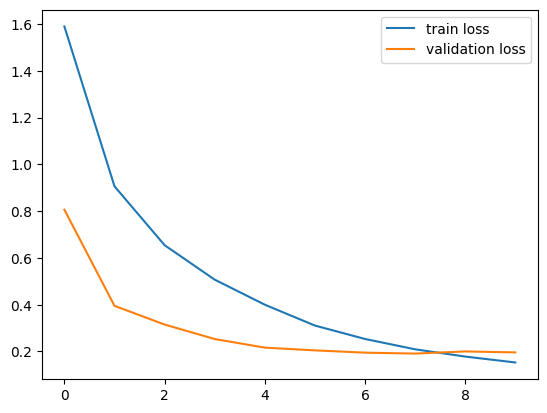

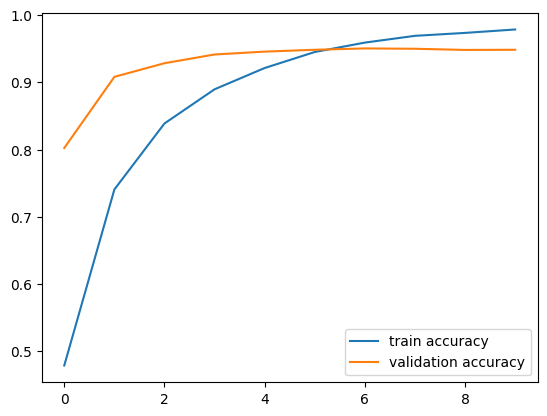

In [32]:
h = history  # history is the output of model.fit(), which contains training metrics like loss and accuracy for each epoch. And h.history is a dictionary
             # storing loss and accuracy values.

# plot the loss value
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

# plot the accuracy value
plt.plot(h.history['acc'], label='train accuracy')
plt.plot(h.history['val_acc'], label='validation accuracy')
plt.legend()
plt.show()

## BUILDING A PREDICTIVE SYSTEM:

Enter the path of the Image:/content/drive/MyDrive/CIFAR-10/Indigo_Airplane.jpg


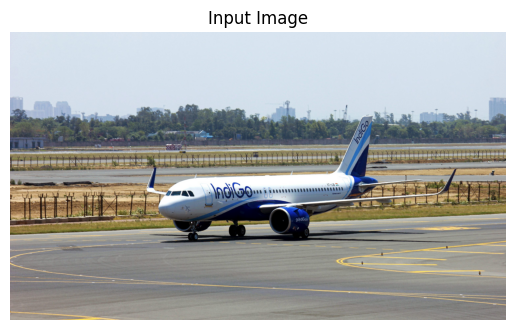

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
The probability of the classes [airplane : 0, automobile : 1, bird : 2, cat : 3, deer : 4, dog : 5, frog : 6, horse : 7, ship : 8, truck : 9] are:  [[9.8983687e-01 1.3134716e-03 2.2290440e-03 1.2453049e-03 1.0662127e-03
  3.3181554e-04 6.8409753e-04 3.2067409e-04 1.5918324e-03 1.3805826e-03]]
The given image is of  airplane


In [34]:
img_path = input('Enter the path of the Image:')           # "/content/drive/MyDrive/CIFAR-10/Indigo_Airplane.jpg"

input_img = cv2.imread(img_path)

# Convert BGR (OpenCV default) to RGB for correct color representation in Matplotlib
input_img_rgb = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.imshow(input_img_rgb)
plt.axis('off')  # Hide axes
plt.title("Input Image")
plt.show()

img_resize = cv2.resize(input_img, (32, 32))

img_scaled = img_resize/255

img_reshape = np.reshape(img_scaled, [1, 32, 32, 3])

img_pred = model.predict(img_reshape)
print('The probability of the classes [airplane : 0, automobile : 1, bird : 2, cat : 3, deer : 4, dog : 5, frog : 6, horse : 7, ship : 8, truck : 9] are: ', img_pred)

img_label = np.argmax(img_pred)

cifar_dic = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

print('The given image is of ', cifar_dic[img_label])